# Analysis of MPI Matrix Multiplication Performance

This notebook analyzes the performance data generated by the `batch_executor.py` script. The goal is to compare four different MPI communication strategies:

1.  **collective**: Using high-level blocking collectives (`MPI_Scatter`, `MPI_Gather`).
2.  **sync**: Using blocking point-to-point communication (`MPI_Send`, `MPI_Recv`).
3.  **async_naive**: A non-blocking implementation with an immediate `MPI_Wait`, simulating blocking behavior.
4.  **async**: An improved non-blocking implementation aiming to overlap communication.

We will generate several plots to visualize performance, scalability, and overhead.

In [7]:
# Step 1: Import Libraries and Load Data
%pip install seaborn pandas matplotlib numpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a visually appealing style for the plots
sns.set_theme(style="whitegrid")

# Load the CSV file. Update the path if your notebook is in a different directory.
# Example: df = pd.read_csv("../mpi_results_local.csv")
try:
    df = pd.read_csv("../report/mpi_results_local.csv")
except FileNotFoundError:
    print("Default 'mpi_results_local.csv' not found.")
    # You might need to point to a specific SLURM job result file
    # file_to_load = "mpi_results_12345.csv"
    # print(f"Attempting to load '{file_to_load}'...")
    # df = pd.read_csv(file_to_load)
    df = pd.DataFrame() # Create empty dataframe if no file is found

if not df.empty:
    df.head()

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Step 2: Data Preprocessing
# The CSV generated by our script is already clean, but we should ensure correct data types.
if not df.empty:
    df["matrix_size"] = df["matrix_size"].astype(int)
    df["num_procs"] = df["num_procs"].astype(int)
    df["total_time_mean"] = df["total_time_mean"].astype(float)
    df["comm_time_mean"] = df["comm_time_mean"].astype(float)
    df["comp_time_mean"] = df["comp_time_mean"].astype(float)
    
    # Display the data types to confirm
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   comm_type        48 non-null     object 
 1   matrix_size      48 non-null     int64  
 2   num_procs        48 non-null     int64  
 3   environment      48 non-null     object 
 4   total_time_mean  48 non-null     float64
 5   total_time_std   48 non-null     float64
 6   comm_time_mean   48 non-null     float64
 7   comm_time_std    48 non-null     float64
 8   comp_time_mean   48 non-null     float64
 9   comp_time_std    48 non-null     float64
 10  repetitions      48 non-null     int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 4.3+ KB


## Chart 1: Runtime vs. Matrix Size

This plot compares the total execution time of each communication method as the size of the matrix increases. This helps us understand how each method performs on larger problems. We will fix the number of processes to the maximum available in our test data for this comparison.

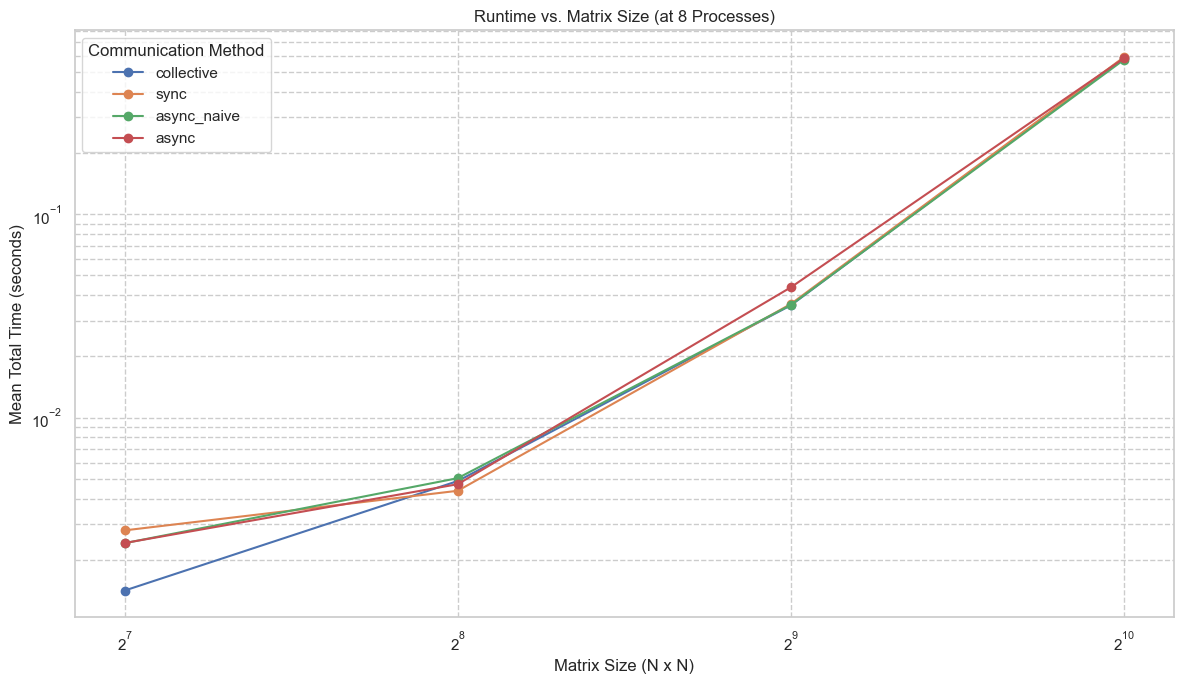

In [10]:
if not df.empty:
    # Find the maximum number of processes used in the tests
    max_procs = df["num_procs"].max()
    
    plt.figure(figsize=(12, 7))
    
    # Filter data for the maximum number of processes
    df_filtered = df[df["num_procs"] == max_procs]
    
    # Plot data for each communication type
    for comm_type in df_filtered["comm_type"].unique():
        subset = df_filtered[df_filtered["comm_type"] == comm_type].sort_values("matrix_size")
        plt.plot(subset["matrix_size"], subset["total_time_mean"], marker='o', linestyle='-', label=comm_type)

    plt.xlabel("Matrix Size (N x N)")
    plt.ylabel("Mean Total Time (seconds)")
    plt.title(f"Runtime vs. Matrix Size (at {max_procs} Processes)")
    plt.xscale("log", base=2)
    plt.yscale("log")
    plt.legend(title="Communication Method")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

## Chart 2: Strong Scaling Analysis

This plot shows how the execution time changes as we increase the number of processes for a **fixed problem size**. This is a classic "strong scaling" analysis. Ideally, doubling the processes should halve the runtime. We'll use the largest matrix size for this chart, as scaling effects are more visible on larger problems.

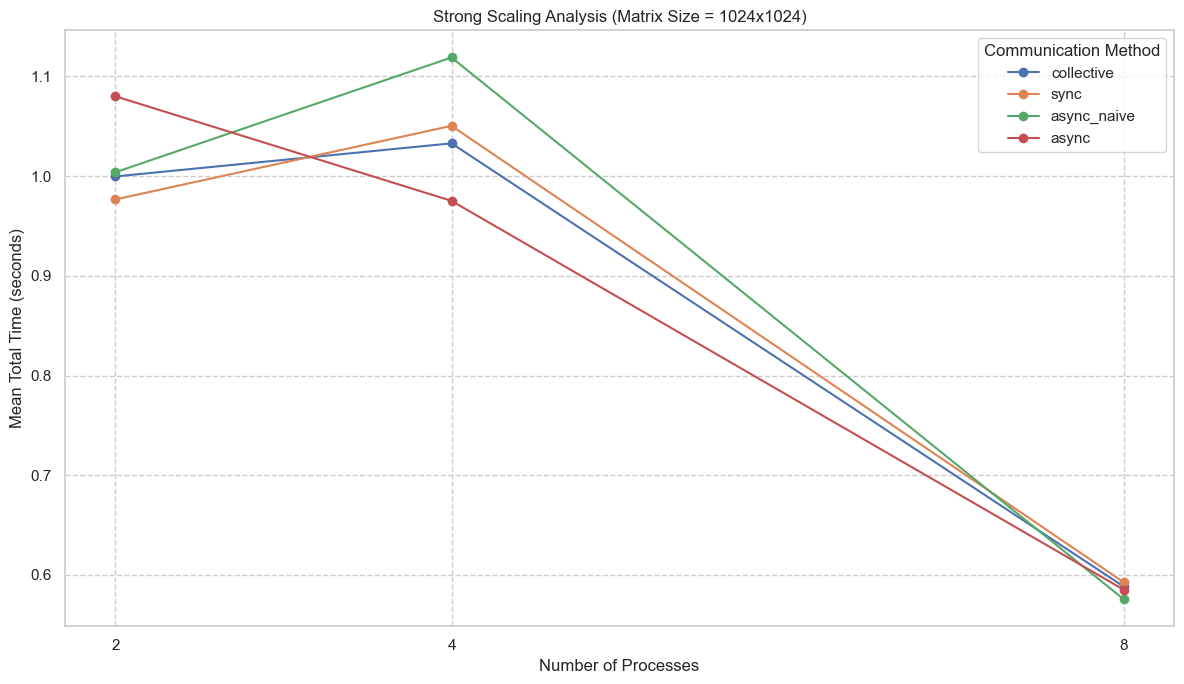

In [11]:
if not df.empty:
    # Find the largest matrix size tested
    largest_matrix = df["matrix_size"].max()

    plt.figure(figsize=(12, 7))

    # Filter data for the largest matrix size
    df_filtered = df[df["matrix_size"] == largest_matrix]

    for comm_type in df_filtered["comm_type"].unique():
        subset = df_filtered[df_filtered["comm_type"] == comm_type].sort_values("num_procs")
        plt.plot(subset["num_procs"], subset["total_time_mean"], marker='o', linestyle='-', label=comm_type)

    plt.xlabel("Number of Processes")
    plt.ylabel("Mean Total Time (seconds)")
    plt.title(f"Strong Scaling Analysis (Matrix Size = {largest_matrix}x{largest_matrix})")
    plt.xticks(df_filtered["num_procs"].unique()) # Ensure x-ticks match process counts
    plt.legend(title="Communication Method")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

## Chart 3: Speedup Analysis

Speedup shows how much faster a parallel algorithm is compared to a baseline. We will calculate the **relative speedup**, using the run with the fewest processes (e.g., p=2) as our baseline ($T_{baseline}$).

Speedup(p) = $T_{baseline}$ / $T_p$

We will also plot an "Ideal Speedup" line for reference.

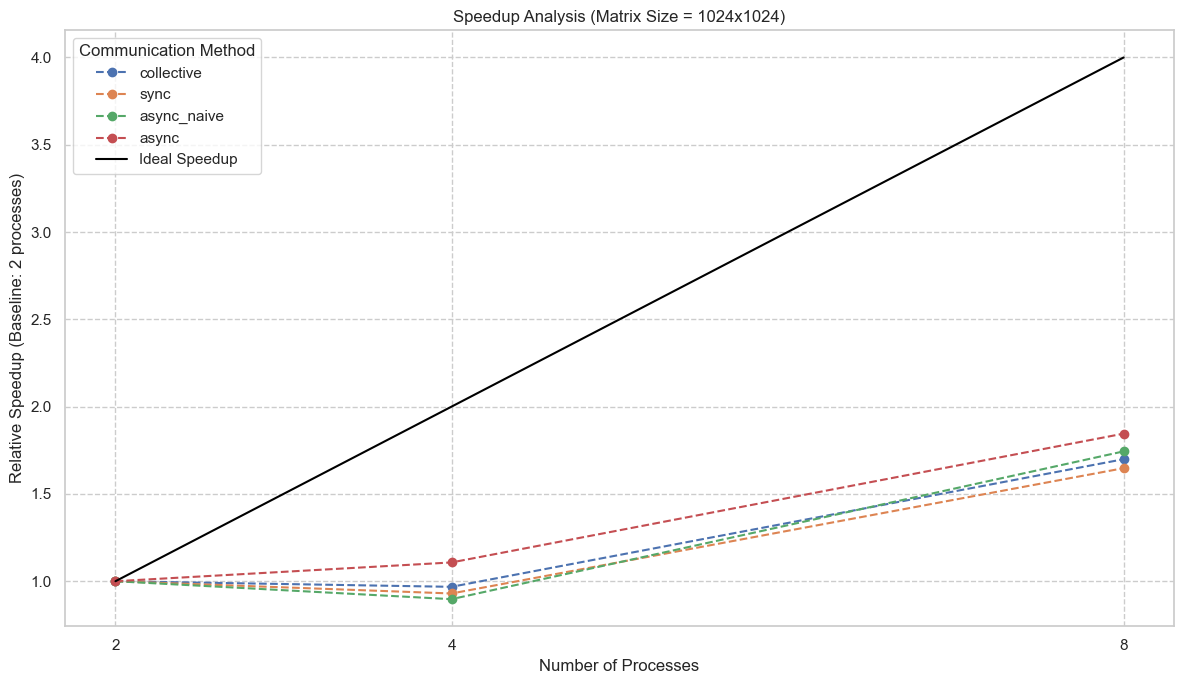

In [12]:
if not df.empty:
    largest_matrix = df["matrix_size"].max()
    df_filtered = df[df["matrix_size"] == largest_matrix]
    
    # Use the minimum number of processes as the baseline for speedup calculation
    baseline_procs = df_filtered["num_procs"].min()
    
    plt.figure(figsize=(12, 7))

    for comm_type in df_filtered["comm_type"].unique():
        subset = df_filtered[df_filtered["comm_type"] == comm_type].sort_values("num_procs")
        
        # Get the baseline time (time for the minimum number of processes)
        baseline_run = subset[subset["num_procs"] == baseline_procs]
        if baseline_run.empty:
            continue
        baseline_time = baseline_run["total_time_mean"].iloc[0]
        
        # Calculate speedup
        subset["speedup"] = baseline_time / subset["total_time_mean"]
        
        plt.plot(subset["num_procs"], subset["speedup"], marker='o', linestyle='--', label=comm_type)

    # Plot ideal speedup line for reference
    procs = sorted(df_filtered["num_procs"].unique())
    ideal_speedup = [p / baseline_procs for p in procs]
    plt.plot(procs, ideal_speedup, linestyle='-', color='black', label='Ideal Speedup')

    plt.xlabel("Number of Processes")
    plt.ylabel(f"Relative Speedup (Baseline: {baseline_procs} processes)")
    plt.title(f"Speedup Analysis (Matrix Size = {largest_matrix}x{largest_matrix})")
    plt.xticks(procs)
    plt.legend(title="Communication Method")
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

## Chart 4: Communication vs. Computation Time Breakdown

This plot is crucial for understanding *why* some methods are faster than others. We use a stacked bar chart to show the proportion of time spent in communication versus computation for a fixed scenario (e.g., largest matrix and maximum processes). This can reveal communication bottlenecks.

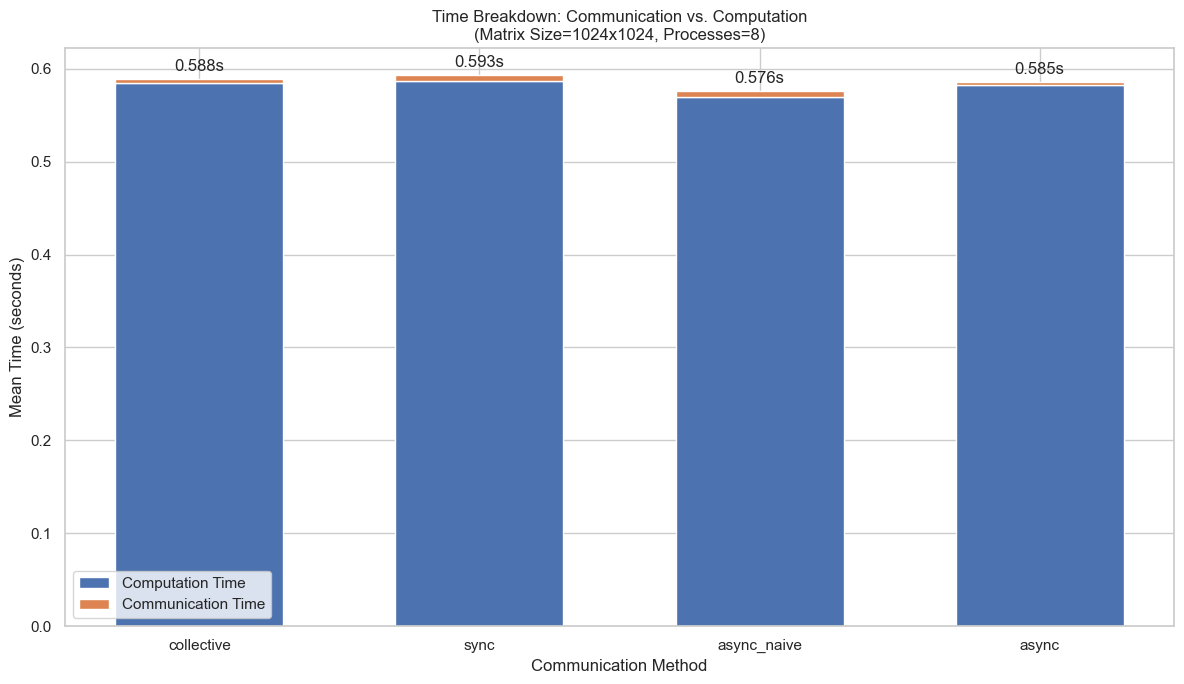

In [13]:
if not df.empty:
    largest_matrix = df["matrix_size"].max()
    max_procs = df["num_procs"].max()
    
    # Filter for the specific scenario
    df_breakdown = df[(df["matrix_size"] == largest_matrix) & (df["num_procs"] == max_procs)]
    
    if df_breakdown.empty:
        print("Data for breakdown chart not found. Please check your CSV file.")
    else:
        # Prepare data for stacked bar chart
        comm_types = df_breakdown["comm_type"]
        comm_times = df_breakdown["comm_time_mean"]
        comp_times = df_breakdown["comp_time_mean"]
        
        width = 0.6  # Width of the bars
        fig, ax = plt.subplots(figsize=(12, 7))

        ax.bar(comm_types, comp_times, width, label='Computation Time')
        ax.bar(comm_types, comm_times, width, bottom=comp_times, label='Communication Time')

        ax.set_xlabel("Communication Method")
        ax.set_ylabel("Mean Time (seconds)")
        ax.set_title(f"Time Breakdown: Communication vs. Computation\n(Matrix Size={largest_matrix}x{largest_matrix}, Processes={max_procs})")
        ax.legend()
        
        # Add labels on top of each bar stack
        for i, (comp, comm) in enumerate(zip(comp_times, comm_times)):
            total = comp + comm
            ax.text(i, total + 0.01 * total, f"{total:.3f}s", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()